<a href="https://colab.research.google.com/github/robinkiplangat/dexter_dashboard/blob/main/notebooks/ElectionWatch_Model_Finetuning_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Understanding the Framework: DISARM**

Before diving into the code, it's clear the **DISARM Framework** : a model for understanding and countering disinformation, structured similarly to a cyber security kill chain (Plan, Prepare, Execute, Assess).

The ["Red: Disinformation Framework"](https://www.disarm.foundation/framework) outlines the tactics, techniques, and procedures (TTPs) used by malicious actors. *Our* goal is to classify real-world data (like tweets from the Nigerian election) into narratives that align with these TTPs.


## **Step 1: Project Setup and Data Loading**

First, we'll set up the environment and load our two key datasets: the Nigerian election tweets and the defined meta-narratives.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Work from Project Folder
%cd '/content/drive/MyDrive/ColabNotebooks/EleWa'

/content/drive/MyDrive/ColabNotebooks/EleWa


In [18]:
ls ./data

 Meta_narratives_in_African_elections.csv
'Nigeria_Election_tweets_dataset<copy>.xlsx'


In [21]:
import pandas as pd
import torch
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
try:
    narratives_df = pd.read_csv("./data/Meta_narratives_in_African_elections.csv")
    tweets_df = pd.read_excel("./data/Nigeria_Election_tweets_dataset<copy>.xlsx", sheet_name='tweets')
    print("Datasets loaded successfully!")
except FileNotFoundError as e:
    print(e)
    print("\nPlease make sure 'Meta_narratives_in_African_elections.csv' and 'Robin_Nigeria_Election_tweets_dataset.xlsx' are in the same directory.")

Datasets loaded successfully!


In [7]:
narratives_df.head(3)

,Meta-Narrative,Description,Tactics Used,Common Locations,Purpose/Effect
0,Foreign Interference / Neocolonialism,Claims that Western nations manipulate electio...,"Fake reports, NGO conspiracies, doctored forei...","Mali, Burkina Faso, Senegal, Niger",Delegitimise pro-West candidates; justify junt...
1,Rigged Elections / Stolen Mandate,Accusations of widespread rigging by incumbent...,"Fake tally sheets, videos of “ballot stuffing,...","Nigeria, Ghana, Sierra Leone",Undermine confidence in the electoral process;...
2,Tech Manipulation Narratives,Suggests that biometric systems or voting tech...,"Fake tech “hacks,” rumours about foreign-manuf...","Nigeria (BVAS), Kenya",Undermine trust in digitised election systems.


In [22]:
tweets_df.head(3)

,Tweet_ID,Twitter_User,RetweetedUser,Date,Retweets,Party,Tweet
0,1579533598625240064,_weyimi,davosala,2022-10-10,10639,Labour,RT @davosala: @PeterObi on transit. As a Keke ...
1,1578291198951030016,imp213x,davosala,2022-10-07,7769,Labour,RT @davosala: @PeterObi on transit. As a Keke ...
2,1575938681676110080,urchilla01,GovWike,2022-09-30,5449,APC,RT @GovWike: It was nice hosting my brother @P...


## **Step 2: Text Preprocessing**

To ensure the model can understand the text, we need to clean it by removing noise like URLs, mentions, and special characters. Our `clean_text` function is perfect for this.

In [23]:

def clean_text(text):
    """
    Cleans input text by removing URLs, mentions, hashtags, punctuation,
    and converting to lowercase.
    """
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

# Apply the cleaning function
tweets_df['cleaned_tweet'] = tweets_df['Tweet'].apply(clean_text)
print("Tweet text has been cleaned.")
display(tweets_df[['Tweet', 'cleaned_tweet']].head())

Tweet text has been cleaned.


,Tweet,cleaned_tweet
0,RT @davosala: @PeterObi on transit. As a Keke ...,rt on transit as a keke rider i carry more t...
1,RT @davosala: @PeterObi on transit. As a Keke ...,rt on transit as a keke rider i carry more t...
2,RT @GovWike: It was nice hosting my brother @P...,rt it was nice hosting my brother once again
3,RT @NgLabour: Your PVC is your Power. Have you...,rt your pvc is your power have you gotten it ...
4,"RT @rosenthal_jon: Oh dear, it is never a good...",rt oh dear it is never a good sign in a presi...


## **Step 3: Narrative Classification (Zero-Shot Approach)**

This is the core of our task. Instead of training a model from scratch (which requires a large, manually labeled dataset), we've used a "zero-shot" approach. We use a pre-trained model to determine how relevant each tweet is to each of your defined narratives.

This method treats the task as a series of binary classifications. For each tweet, we ask the model nine questions, one for each narrative (e.g., "Does this tweet fit the 'Rigged Elections' narrative?").

In [24]:
# Load a pre-trained model for sequence classification.
# 'distilbert-base-uncased-finetuned-sst-2-english' is good for determining relevance/sentiment.
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier_model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Prepare the narratives for classification
formatted_narratives = {row['Meta-Narrative']: row['Description'] for index, row in narratives_df.iterrows()}

def classify_tweet_narratives(tweet, narratives_dict, tokenizer, model):
    """
    Classifies a tweet against a dictionary of narratives.
    Returns a list of narratives that are predicted to be relevant.
    """
    predicted_categories = []
    with torch.no_grad():
        for narrative, description in narratives_dict.items():
            # We check the premise (narrative) and hypothesis (tweet)
            inputs = tokenizer(description, tweet, return_tensors="pt", truncation=True, padding=True)
            logits = model(**inputs).logits

            # The model outputs logits for 'negative' and 'positive' classes.
            # We'll take the 'positive' logit as a score for relevance.
            # A higher score means the tweet is more likely related to the narrative.
            score = logits[0][1].item() # Logit for the 'positive' class

            # Set a threshold for relevance
            if score > 0.5: # This threshold can be adjusted
                predicted_categories.append(narrative)

    return predicted_categories

# Apply the classification to a sample of the data for demonstration
# Note: Running on all tweets can be time-consuming.
sample_tweets = tweets_df.head(20).copy()
sample_tweets['predicted_narratives'] = sample_tweets['cleaned_tweet'].apply(
    lambda tweet: classify_tweet_narratives(tweet, formatted_narratives, tokenizer, classifier_model)
)

print("\nNarrative classification complete.")
display(sample_tweets[['cleaned_tweet', 'predicted_narratives']].head())

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Narrative classification complete.


,cleaned_tweet,predicted_narratives
0,rt on transit as a keke rider i carry more t...,[]
1,rt on transit as a keke rider i carry more t...,[]
2,rt it was nice hosting my brother once again,"[Divine / Prophetic Endorsements, Populist “Cl..."
3,rt your pvc is your power have you gotten it ...,[]
4,rt oh dear it is never a good sign in a presi...,[]



## **Step 4: From Zero-Shot to Fine-Tuning**

The zero-shot method is a fantastic starting point. To build a more accurate, specialized model, we need to **fine-tune**. This involves training a base model on our own labeled data.

**What is Fine-Tuning?**
Fine-tuning takes a powerful, general-purpose language model (like `bert-base-uncased` or `roberta-base`) and further trains it on a specific dataset, making it an expert on that particular task.

**Workflow for Fine-Tuning:**

1.  **Create a Labeled Dataset**: This is the most critical step. You need to manually label a sample of your tweets. For each tweet, you would decide which of the nine narratives apply. This is a *multi-label* problem, as one tweet can contain several narratives. Your dataset should look something like this:

| text | Foreign Interference | Rigged Elections | Tech Manipulation | ... |
| :--- | :--- | :--- | :--- | :--- |
| "They are using foreign machines to rig the vote!" | 1 | 1 | 1 | ... |
| "The incumbent must not be allowed to steal this mandate" | 0 | 1 | 0 | ... |
| "A clean outsider is our only hope for this nation." | 0 | 0 | 0 | ... |

2.  **Choose a Base Model**: A model like `bert-base-cased` or, for better performance on diverse languages, `xlm-roberta-base` would be a strong choice.

3.  **The Training Process**: You would use the Hugging Face `Trainer` API. It's a powerful utility that handles the entire training and evaluation loop for you. You would configure it for a multi-label classification problem.

4.  **Evaluate**: After training, you would use metrics like F1-score, precision, and recall to see how well your fine-tuned model performs on a separate test set.

This process requires a significant effort in data labeling but results in a much more accurate and reliable model tailored specifically to Nigerian election misinformation.


## **Step 5: Analysis and Visualization**

Once you have your classifications (either from the zero-shot method or a future fine-tuned model), you can generate powerful insights. A temporal analysi is a great example.

Here’s how you can create a timeline of narrative prevalence:

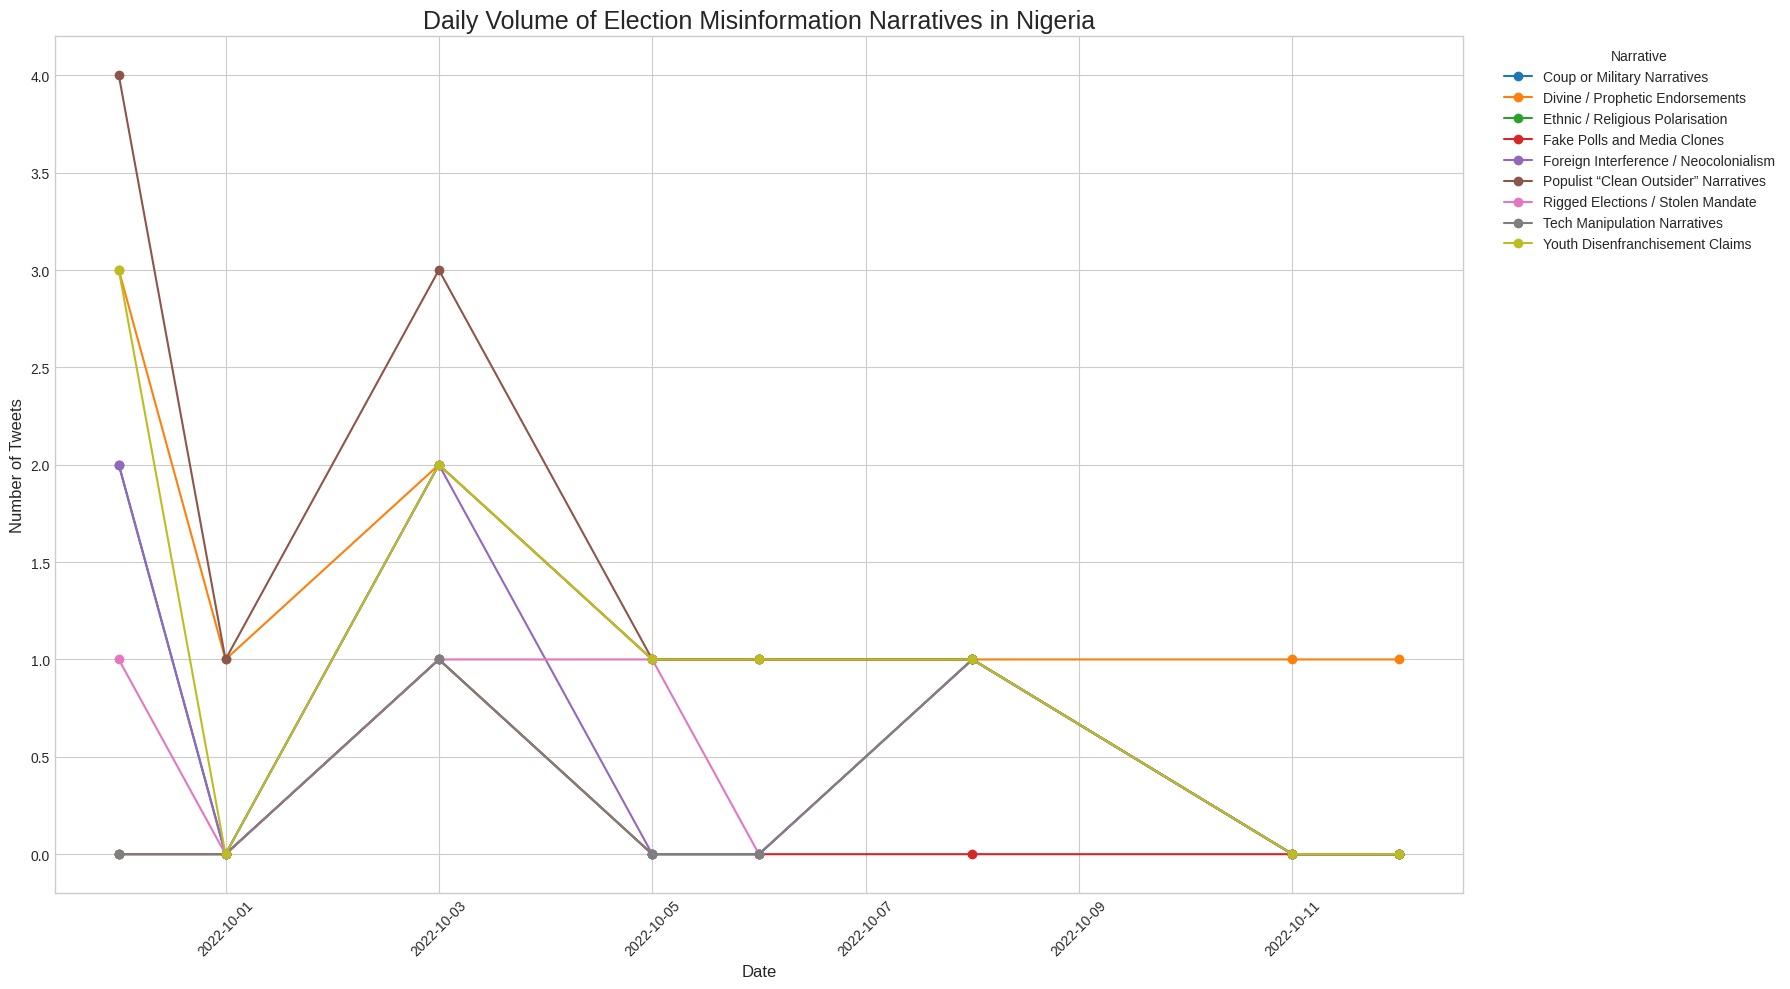

In [25]:
# Ensure the 'Date' column is in datetime format
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'])

# We'll use the full dataframe for this analysis, assuming it's classified
# For now, we'll populate it with the sample results for demonstration
tweets_df['predicted_narratives'] = tweets_df['cleaned_tweet'].apply(
    lambda tweet: classify_tweet_narratives(tweet, formatted_narratives, tokenizer, classifier_model)
)


# Explode the dataframe to have one row per tweet-narrative pair
narrative_trends = tweets_df.explode('predicted_narratives').dropna(subset=['predicted_narratives'])

# Count narrative occurrences per day
daily_counts = narrative_trends.groupby([narrative_trends['Date'].dt.date, 'predicted_narratives']).size().unstack(fill_value=0)

# Plotting the trends
plt.style.use('seaborn-v0_8-whitegrid')
daily_counts.plot(kind='line', figsize=(18, 10), marker='o', linestyle='-')
plt.title('Daily Volume of Election Misinformation Narratives in Nigeria', fontsize=18)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Narrative', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

This pipeline provides a complete workflow, from data ingestion to classification and analysis.

The zero-shot approach provides immediate results, which can help guide the more intensive process of creating a labeled dataset for true fine-tuning.